In [ ]:
import torch
import time
import numpy as np
import torchtext
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import GradScaler, autocast
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'


In [ ]:
def evaluate(net, loader, criterion):
    """Evaluate the network on the validation set.

    Args:
        net: PyTorch neural network object
        loader: PyTorch data loader for the validation set
        criterion: The loss function
    Returns:
        err: A scalar for the avg classification error over the validation set
        loss: A scalar for the average loss function over the validation set
    """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
          inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total_err += (predicted != labels).sum().item()
        total_loss += loss.item()
        total_epoch += labels.size(0)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
def get_data_loader(dataset,batch_size):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

In [ ]:
glove = torchtext.vocab.GloVe(name = '6B', dim=50)
dataset = pd.read_csv('train.csv')
# print(test_dataset.columns)
dataset.drop(columns=['Unnamed: 0'], inplace=True)
# Find the maximum length of the lyrics in the dataset



In [ ]:
# Convert the labels to numerical format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(dataset['mood_cats'].values)
labels = encoded_labels

# Tokenizer
tokenizer = get_tokenizer('basic_english')

# Build vocabulary
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(dataset['lyrics']), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Tokenize and numericalize the sequences
def numericalize(text):
    return [vocab[token] for token in tokenizer(text)]

numericalized_data = [numericalize(text) for text in dataset['lyrics']]

# Pad the sequences
padded_sequences = pad_sequence([torch.tensor(seq) for seq in numericalized_data], batch_first=True)

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [ ]:

# Create data loaders
batch_size = 64
# train_dataset = create_dataset(train_dataFrame, vocab)

# train_loader, val_loader= get_data_loader(train_dataset, batch_size)

# for inputs, labels in train_loader:
#     print(inputs.shape, labels.shape)
#     break
# Convert the data to PyTorch tensors
X_train_tensor = X_train.long()
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

X_val_tensor = X_val.long()
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = get_data_loader(train_dataset, batch_size=batch_size)
val_loader = get_data_loader(val_dataset, batch_size=batch_size)

In [ ]:
print(len(train_dataset))

2765


In [ ]:
class simpleRnn(nn.Module):
    def __init__(self, input_size, hidden_size, num_layer, num_class):
        super(simpleRnn, self).__init__()
        self.name = "simpleRnn"
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layer, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_class)
    def forward(self, x):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        x = self.emb(x).to(device)  # Ensure x is on the correct device
        # Set the initial hidden states
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)  # Move h0 to the same device as x
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last step to the classifier
        return self.fc(out[:,-1,:])



In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(BiLSTM, self).__init__()
        self.name = "BiLSTM"
        self.embedding = nn.Embedding.from_pretrained(glove.vectors)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional

    def forward(self, x):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        embedded = self.embedding(x).to(device)
        lstm_out, _ = self.lstm(embedded)
        final_output = lstm_out[:, -1, :]  # Get the output of the last time step
        return self.fc(final_output)

In [ ]:
def train_nn(model, batch_size=64, learning_rate=0.01, num_epochs=30):
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0.0
        # current_lr = optimizer.param_group[0]['lr']
        # print(f'Epoch: {epoch+1}, LR: {current_lr}')
        for i, data in enumerate(train_loader, 0):
            inputs, targets = data
            if torch.cuda.is_available():
                  inputs, targets = inputs.cuda(), targets.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # Calculate accurac iny
            _, predicted = torch.max(outputs.data, 1)
            total_train_err += (predicted != targets).sum().item()
            total_train_loss += loss.item()
            total_epoch += targets.size(0)

        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(model, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |" +
                   "Validation err: {}, Validation loss: {}").format(
                epoch + 1,
                train_err[epoch],
                train_loss[epoch],
                val_err[epoch],
                val_loss[epoch]))
        scheduler.step()
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [ ]:
# model = simpleRnn(50, 100, 1, 4)

model = BiLSTM(50,100, 4, 3, 0.2)
if torch.cuda.is_available():
    model = model.cuda()
train_nn(model, batch_size=64, learning_rate=0.01, num_epochs=30)

Epoch 1: Train err: 0.7584086799276673, Train loss: 1.386891695586118 |Validation err: 0.7601156069364162, Validation loss: 1.3871452483263882
Epoch 2: Train err: 0.752622061482821, Train loss: 1.3864391066811301 |Validation err: 0.7384393063583815, Validation loss: 1.3867337920448997
Epoch 3: Train err: 0.7461121157323689, Train loss: 1.3868489807302302 |Validation err: 0.7601156069364162, Validation loss: 1.3872221383181484
Epoch 4: Train err: 0.7569620253164557, Train loss: 1.386757344007492 |Validation err: 0.7572254335260116, Validation loss: 1.3866824236783115
Epoch 5: Train err: 0.7450271247739603, Train loss: 1.3863321163437583 |Validation err: 0.7702312138728323, Validation loss: 1.387102484703064
Epoch 6: Train err: 0.7681735985533454, Train loss: 1.3867868266322396 |Validation err: 0.7398843930635838, Validation loss: 1.3869684934616089
Epoch 7: Train err: 0.7497287522603978, Train loss: 1.386783930388364 |Validation err: 0.7630057803468208, Validation loss: 1.38711590116674

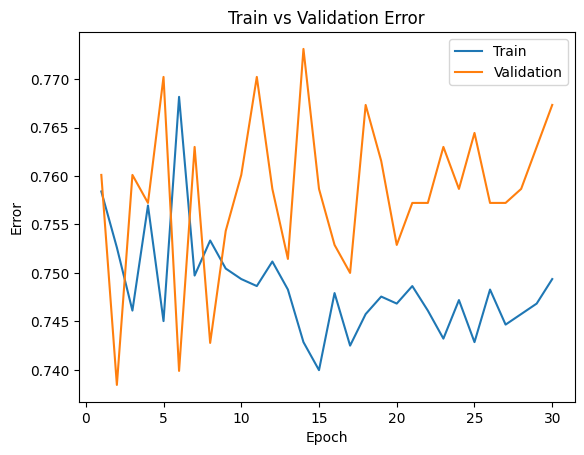

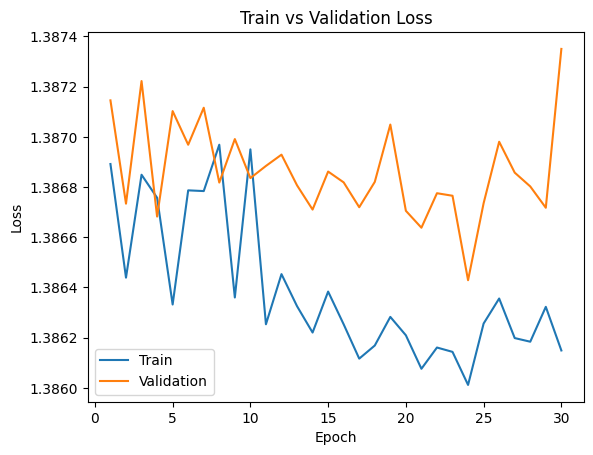

In [ ]:
model_path = get_model_name("BiLSTM", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)